In [14]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist as mn
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [15]:
# Training Parameters
learning_rate = 0.01
num_steps = 500
batch_size = 128
n_images = 10000

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [16]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters 
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)

        # Convolution Layer with 64 filters 
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


In [17]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [18]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpsi0nf6pg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1ce389e9b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
# Define the input function for training
X_tr={'images': mnist.train.images}
Y_tr=mnist.train.labels
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=X_tr, y=Y_tr,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpsi0nf6pg/model.ckpt.
INFO:tensorflow:loss = 2.3089032, step = 1


In [8]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-17-04:00:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpkden2xf4/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-17-04:00:33
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.9425, global_step = 500, loss = 0.18497896
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpkden2xf4/model.ckpt-500


{'accuracy': 0.9425, 'loss': 0.18497896, 'global_step': 500}

In [9]:
write = 0
if write==1:
    f = open("shade.txt", 'w')

# Predict single images
# Get images from test set
test_images = mnist.test.images[:n_images]
test_label=mnist.test.labels[:n_images]

# # reshape to be [samples][pixels][width][height]
X_test = test_images
y_test = test_label
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# # convert from int to float
X_test = X_test.astype('float32')

X_test_backup = X_test
Y_test_backup = y_test

yBackup = []
pBackup = []

val = 0.0001
for j in range(0,100):
    X_test = X_test_backup
    y_test = Y_test_backup
    mValue = val*j
    X_test = (X_test + (mValue))%1
    # Prepare the input data
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'images': X_test}, shuffle=False)
    # Use the model to predict the images class
    preds = list(model.predict(input_fn))

    accuracy = 0.0

    # Display
    for i in range(n_images):
#         plt.imshow(np.reshape(X_test[i], [28, 28]), cmap='gray')
#         plt.show()
        if (preds[i] == y_test[i]):
            accuracy = accuracy + 1/n_images
#         print("Model prediction:", preds[i], "  Correct value:", y_test[i])
    print("Accuracy is: ", accuracy)
    yBackup.append(y_test)
    pBackup.append(preds)
    if write==1:
        f.write(str(mValue)+"\t"+str(accuracy)+"\n")
if write==1:
    f.close()
print("Done!")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpkden2xf4/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.9141999999999156
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpkden2xf4/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.9141999999999156
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpkden2xf4/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
A

Accuracy is:  0.9159999999999154
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpkden2xf4/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.9159999999999154
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpkden2xf4/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.9160999999999154
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpkden2xf4/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorf

INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.8659999999999209
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpkden2xf4/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.8663999999999209
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpkden2xf4/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.8665999999999209
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpkden2xf4/model.ckpt-500
INFO:te

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.8676999999999208
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpkden2xf4/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.8676999999999208
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpkden2xf4/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.8674999999999208
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7733999999999311
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpkden2xf4/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7735999999999311
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpkden2xf4/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy is:  0.7735999999999311
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000

In [10]:
print(len(pBackup[0]))

10000


In [11]:
yTotal = [0]*10

for y in y_test:
    yTotal[y] = yTotal[y]+1

aMatrix = []
for i in range(len(pBackup)):
    print("\n\nYmatrix for rotation %d"%(i))
    yMatrix = [[0]*10 for i in range(10)]
    for j in range(len(pBackup[i])):
        yMatrix[yBackup[i][j]][pBackup[i][j]] += 1

    sum = 0
    
    for x in range(len(yMatrix)):
        for y in range(len(yMatrix[x])):
            yMatrix[x][y] = round(yMatrix[x][y]/yTotal[x], 3)

    aMatrix.append(yMatrix)
    for x in yMatrix:
        for y in x:
            print("%f" % (y),end=" ")
        print()
    



Ymatrix for rotation 0
0.934000 0.003000 0.038000 0.002000 0.002000 0.009000 0.003000 0.008000 0.001000 0.000000 
0.003000 0.963000 0.008000 0.003000 0.000000 0.015000 0.003000 0.003000 0.004000 0.000000 
0.002000 0.014000 0.960000 0.005000 0.005000 0.001000 0.001000 0.011000 0.002000 0.000000 
0.000000 0.008000 0.051000 0.901000 0.001000 0.018000 0.000000 0.016000 0.004000 0.001000 
0.002000 0.002000 0.011000 0.003000 0.946000 0.012000 0.002000 0.017000 0.002000 0.002000 
0.002000 0.000000 0.002000 0.010000 0.003000 0.952000 0.008000 0.004000 0.016000 0.002000 
0.013000 0.008000 0.026000 0.001000 0.009000 0.017000 0.923000 0.000000 0.003000 0.000000 
0.002000 0.009000 0.029000 0.009000 0.010000 0.009000 0.000000 0.929000 0.002000 0.002000 
0.024000 0.012000 0.026000 0.004000 0.015000 0.042000 0.004000 0.013000 0.856000 0.003000 
0.006000 0.015000 0.004000 0.004000 0.112000 0.033000 0.001000 0.048000 0.003000 0.775000 


Ymatrix for rotation 1
0.934000 0.003000 0.038000 0.002000 0.00

0.934000 0.003000 0.038000 0.002000 0.002000 0.009000 0.002000 0.009000 0.001000 0.000000 
0.003000 0.964000 0.007000 0.004000 0.000000 0.015000 0.003000 0.003000 0.003000 0.000000 
0.003000 0.016000 0.957000 0.004000 0.005000 0.001000 0.001000 0.012000 0.002000 0.000000 
0.000000 0.004000 0.051000 0.902000 0.001000 0.019000 0.000000 0.017000 0.004000 0.002000 
0.002000 0.002000 0.009000 0.002000 0.949000 0.013000 0.002000 0.016000 0.002000 0.002000 
0.002000 0.001000 0.001000 0.011000 0.003000 0.951000 0.008000 0.003000 0.017000 0.002000 
0.013000 0.008000 0.025000 0.002000 0.009000 0.016000 0.924000 0.000000 0.003000 0.000000 
0.002000 0.010000 0.027000 0.008000 0.010000 0.008000 0.000000 0.932000 0.002000 0.002000 
0.025000 0.014000 0.026000 0.007000 0.015000 0.036000 0.005000 0.014000 0.854000 0.003000 
0.006000 0.016000 0.004000 0.004000 0.106000 0.028000 0.001000 0.048000 0.003000 0.785000 


Ymatrix for rotation 16
0.934000 0.003000 0.038000 0.002000 0.002000 0.009000 0.002000 0

0.003000 0.015000 0.956000 0.005000 0.005000 0.001000 0.002000 0.012000 0.002000 0.000000 
0.000000 0.004000 0.050000 0.899000 0.001000 0.019000 0.000000 0.021000 0.004000 0.002000 
0.002000 0.002000 0.009000 0.002000 0.950000 0.013000 0.002000 0.015000 0.002000 0.002000 
0.002000 0.001000 0.001000 0.011000 0.003000 0.951000 0.008000 0.003000 0.017000 0.002000 
0.013000 0.008000 0.026000 0.002000 0.009000 0.015000 0.923000 0.000000 0.004000 0.000000 
0.002000 0.011000 0.024000 0.007000 0.010000 0.009000 0.000000 0.935000 0.001000 0.002000 
0.025000 0.016000 0.026000 0.006000 0.016000 0.034000 0.005000 0.014000 0.854000 0.003000 
0.006000 0.017000 0.003000 0.003000 0.101000 0.028000 0.001000 0.047000 0.003000 0.792000 


Ymatrix for rotation 30
0.936000 0.003000 0.035000 0.003000 0.002000 0.009000 0.002000 0.009000 0.001000 0.000000 
0.003000 0.967000 0.006000 0.004000 0.000000 0.013000 0.003000 0.003000 0.003000 0.000000 
0.003000 0.015000 0.956000 0.005000 0.005000 0.001000 0.002000 0

0.002000 0.009000 0.076000 0.848000 0.001000 0.025000 0.001000 0.034000 0.004000 0.001000 
0.002000 0.011000 0.013000 0.001000 0.837000 0.026000 0.004000 0.087000 0.003000 0.015000 
0.001000 0.002000 0.001000 0.016000 0.001000 0.946000 0.009000 0.006000 0.016000 0.002000 
0.021000 0.015000 0.056000 0.003000 0.024000 0.037000 0.839000 0.000000 0.005000 0.000000 
0.003000 0.011000 0.029000 0.005000 0.010000 0.011000 0.000000 0.928000 0.000000 0.004000 
0.025000 0.020000 0.045000 0.023000 0.014000 0.065000 0.002000 0.030000 0.772000 0.005000 
0.007000 0.016000 0.006000 0.009000 0.120000 0.042000 0.000000 0.115000 0.004000 0.682000 


Ymatrix for rotation 44
0.891000 0.005000 0.067000 0.005000 0.005000 0.012000 0.002000 0.010000 0.002000 0.000000 
0.004000 0.957000 0.009000 0.004000 0.002000 0.018000 0.001000 0.004000 0.003000 0.000000 
0.004000 0.013000 0.948000 0.007000 0.003000 0.002000 0.003000 0.016000 0.005000 0.000000 
0.002000 0.009000 0.077000 0.847000 0.001000 0.025000 0.001000 0

0.001000 0.002000 0.001000 0.016000 0.001000 0.945000 0.009000 0.006000 0.017000 0.002000 
0.022000 0.016000 0.056000 0.002000 0.025000 0.037000 0.837000 0.000000 0.005000 0.000000 
0.002000 0.012000 0.028000 0.005000 0.010000 0.011000 0.000000 0.927000 0.000000 0.006000 
0.026000 0.021000 0.045000 0.023000 0.015000 0.061000 0.002000 0.031000 0.771000 0.006000 
0.007000 0.016000 0.006000 0.009000 0.119000 0.038000 0.000000 0.107000 0.005000 0.694000 


Ymatrix for rotation 58
0.892000 0.005000 0.066000 0.005000 0.005000 0.012000 0.002000 0.010000 0.002000 0.000000 
0.004000 0.959000 0.009000 0.004000 0.002000 0.016000 0.001000 0.004000 0.003000 0.000000 
0.005000 0.013000 0.948000 0.007000 0.003000 0.002000 0.003000 0.016000 0.004000 0.000000 
0.002000 0.007000 0.077000 0.847000 0.001000 0.025000 0.001000 0.036000 0.004000 0.001000 
0.001000 0.013000 0.013000 0.001000 0.839000 0.023000 0.005000 0.085000 0.002000 0.017000 
0.001000 0.002000 0.001000 0.016000 0.001000 0.944000 0.010000 0

0.024000 0.016000 0.053000 0.002000 0.025000 0.038000 0.837000 0.000000 0.005000 0.000000 
0.001000 0.012000 0.027000 0.005000 0.011000 0.011000 0.000000 0.927000 0.001000 0.006000 
0.029000 0.020000 0.046000 0.023000 0.016000 0.060000 0.002000 0.032000 0.767000 0.006000 
0.007000 0.017000 0.006000 0.008000 0.116000 0.036000 0.000000 0.102000 0.005000 0.704000 


Ymatrix for rotation 72
0.899000 0.006000 0.058000 0.005000 0.005000 0.011000 0.002000 0.010000 0.003000 0.000000 
0.003000 0.961000 0.010000 0.004000 0.002000 0.015000 0.001000 0.004000 0.002000 0.000000 
0.006000 0.015000 0.944000 0.007000 0.003000 0.002000 0.003000 0.018000 0.003000 0.000000 
0.002000 0.008000 0.076000 0.844000 0.001000 0.026000 0.001000 0.037000 0.004000 0.002000 
0.002000 0.013000 0.011000 0.001000 0.840000 0.022000 0.006000 0.085000 0.002000 0.017000 
0.001000 0.002000 0.001000 0.016000 0.001000 0.944000 0.010000 0.006000 0.017000 0.002000 
0.024000 0.016000 0.053000 0.002000 0.025000 0.038000 0.837000 0

0.026000 0.033000 0.081000 0.033000 0.020000 0.089000 0.004000 0.068000 0.642000 0.005000 
0.007000 0.022000 0.017000 0.011000 0.124000 0.065000 0.000000 0.223000 0.008000 0.523000 


Ymatrix for rotation 86
0.746000 0.008000 0.146000 0.014000 0.015000 0.041000 0.005000 0.018000 0.006000 0.000000 
0.004000 0.923000 0.024000 0.005000 0.004000 0.017000 0.001000 0.009000 0.009000 0.004000 
0.004000 0.020000 0.926000 0.012000 0.003000 0.004000 0.002000 0.026000 0.003000 0.000000 
0.003000 0.015000 0.131000 0.707000 0.001000 0.042000 0.001000 0.096000 0.004000 0.001000 
0.007000 0.022000 0.017000 0.001000 0.708000 0.039000 0.004000 0.169000 0.005000 0.027000 
0.001000 0.003000 0.011000 0.025000 0.000000 0.934000 0.006000 0.007000 0.010000 0.003000 
0.023000 0.024000 0.148000 0.015000 0.033000 0.070000 0.680000 0.000000 0.007000 0.000000 
0.001000 0.017000 0.030000 0.012000 0.010000 0.014000 0.000000 0.912000 0.002000 0.003000 
0.026000 0.033000 0.081000 0.033000 0.020000 0.089000 0.004000 0

0.007000 0.021000 0.017000 0.009000 0.121000 0.065000 0.000000 0.217000 0.009000 0.534000 


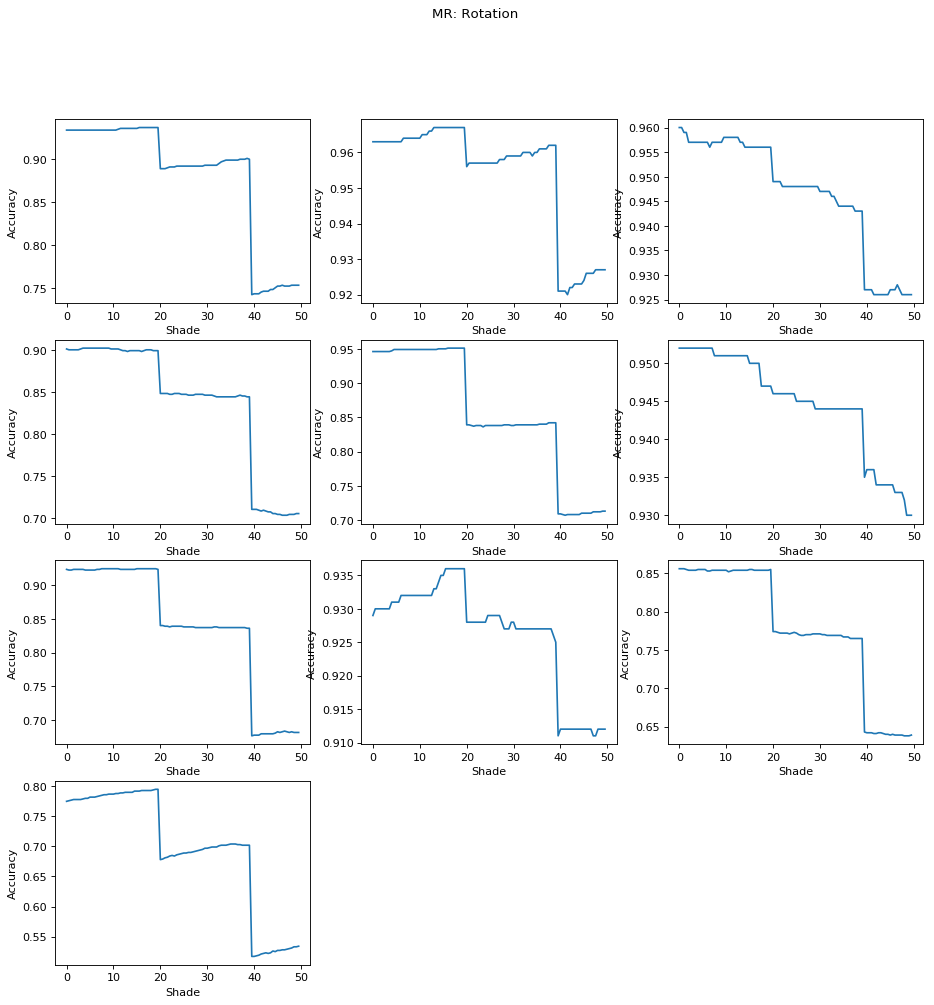

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')

zero = []
for j in range(10):
    zero = []
    for i in range(len(aMatrix)):
        zero.append(aMatrix[i][j][j])
    plt.subplot(4,3,j+1)
    plt.plot(np.arange(0,50,0.5),zero)
    plt.xlabel("Shade")
    plt.ylabel("Accuracy")
plt.suptitle("MR: Rotation")
plt.show()

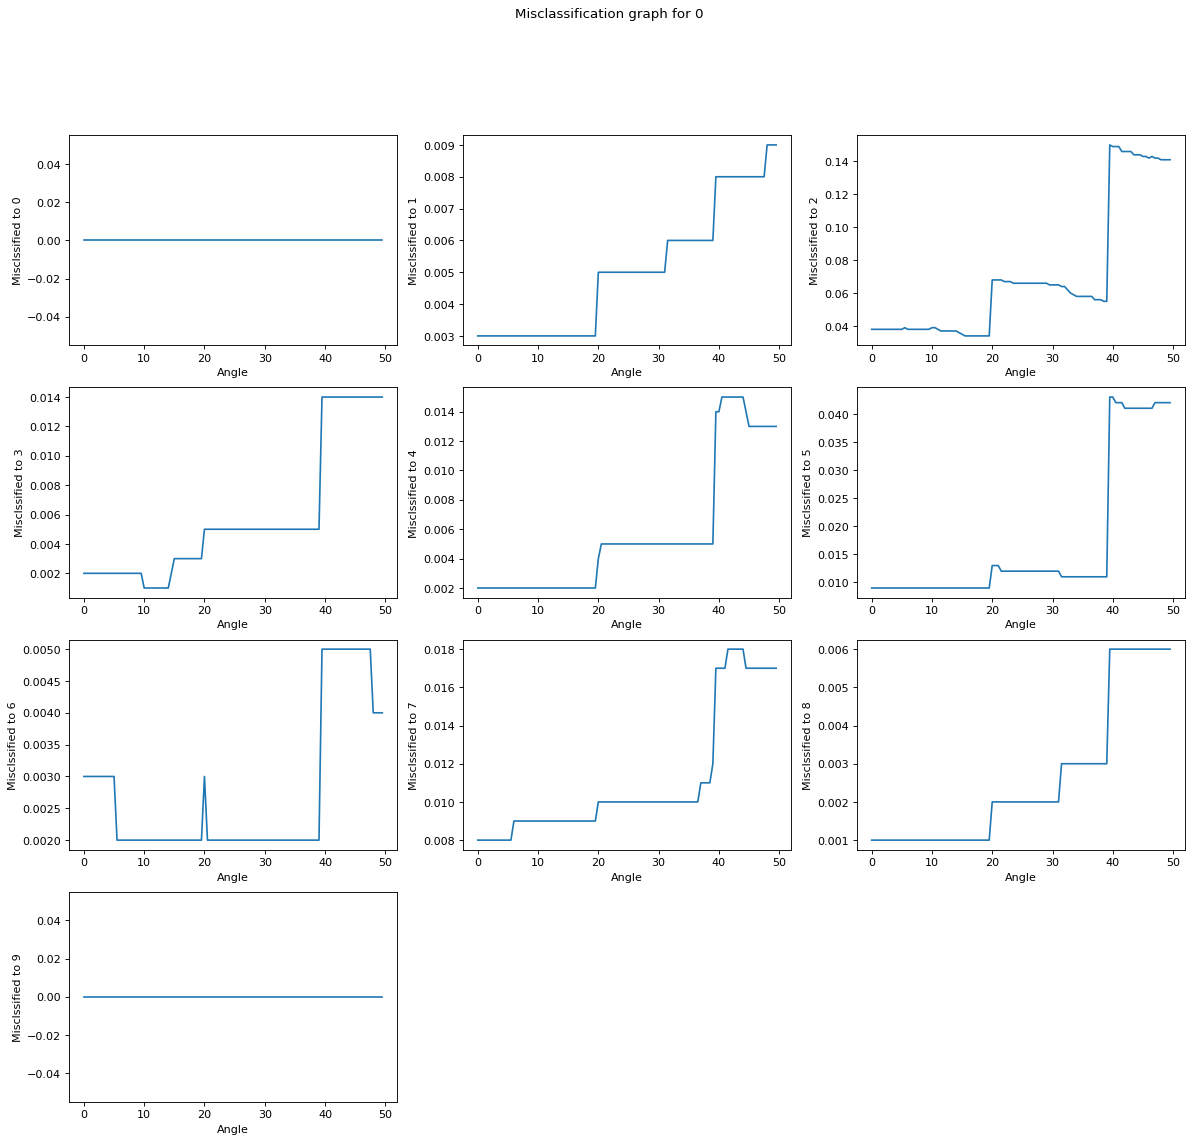

---------------------------------------------------------------------------------------------------------------------


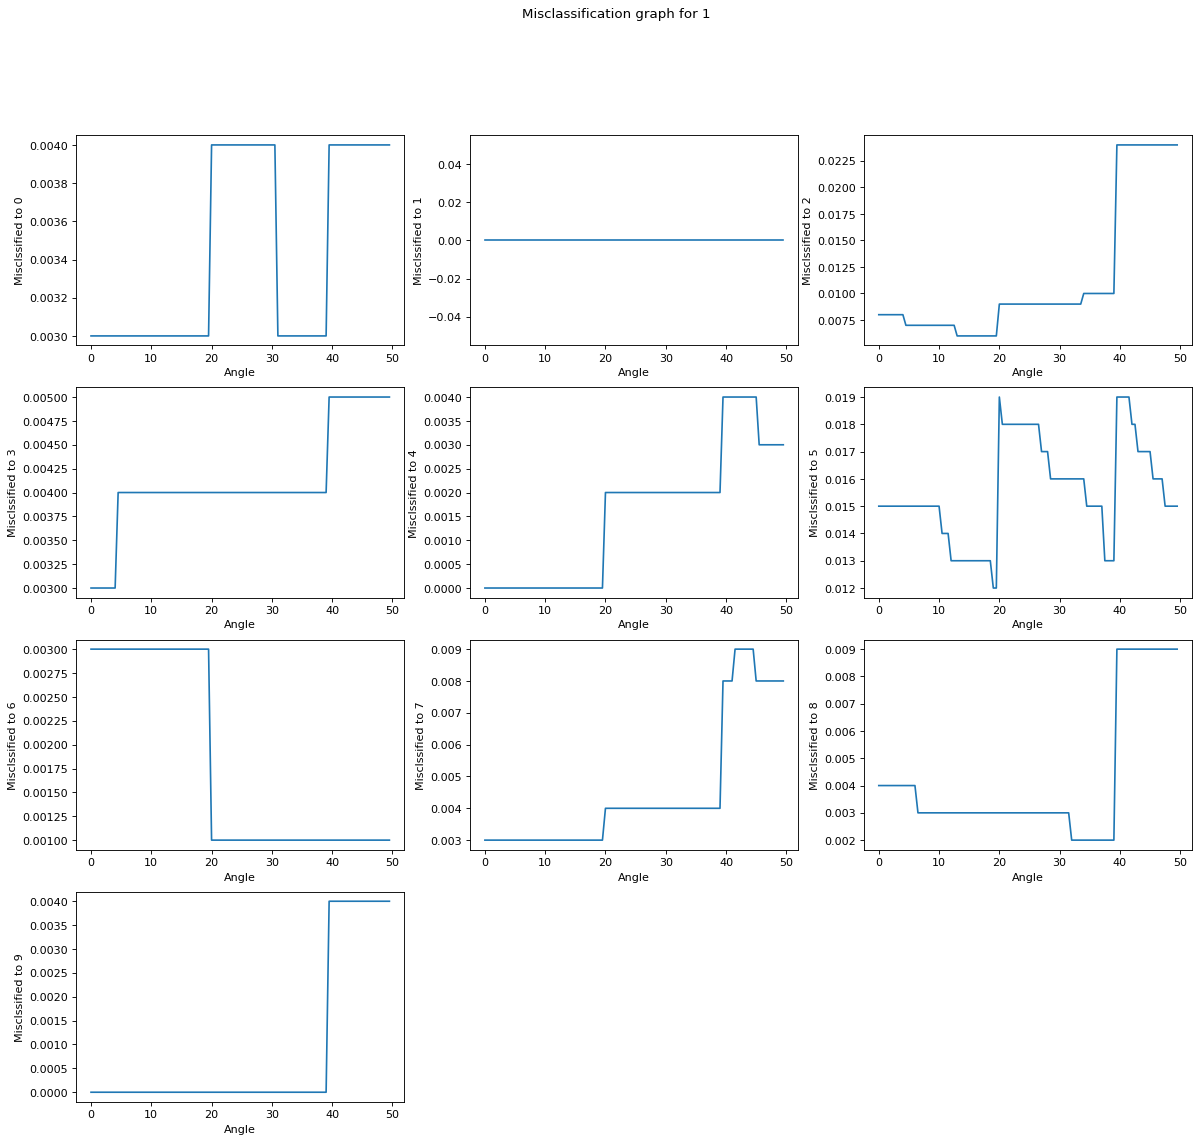

---------------------------------------------------------------------------------------------------------------------


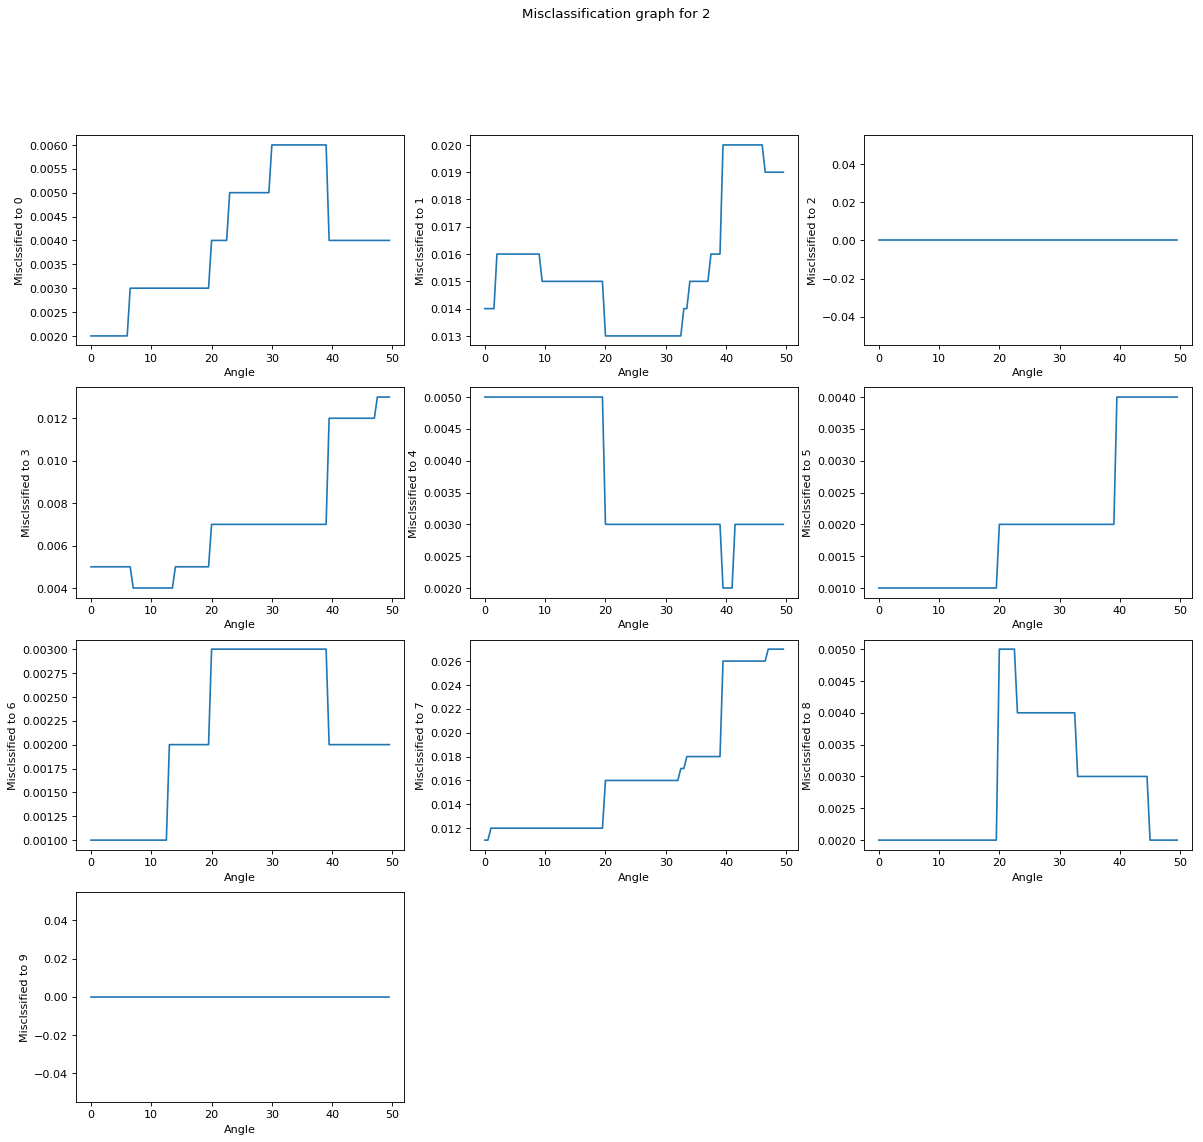

---------------------------------------------------------------------------------------------------------------------


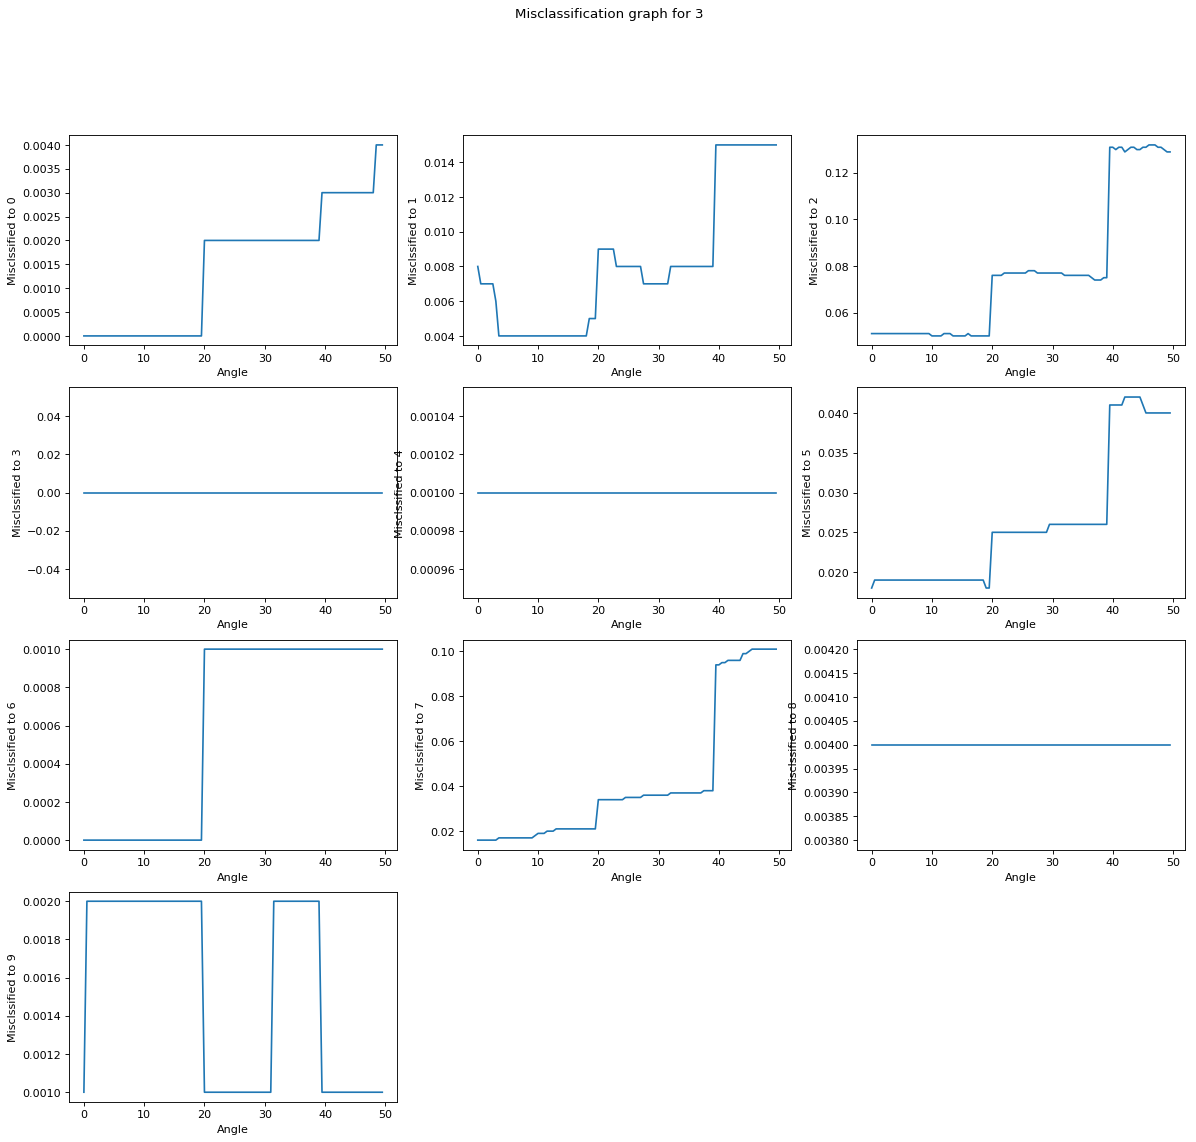

---------------------------------------------------------------------------------------------------------------------


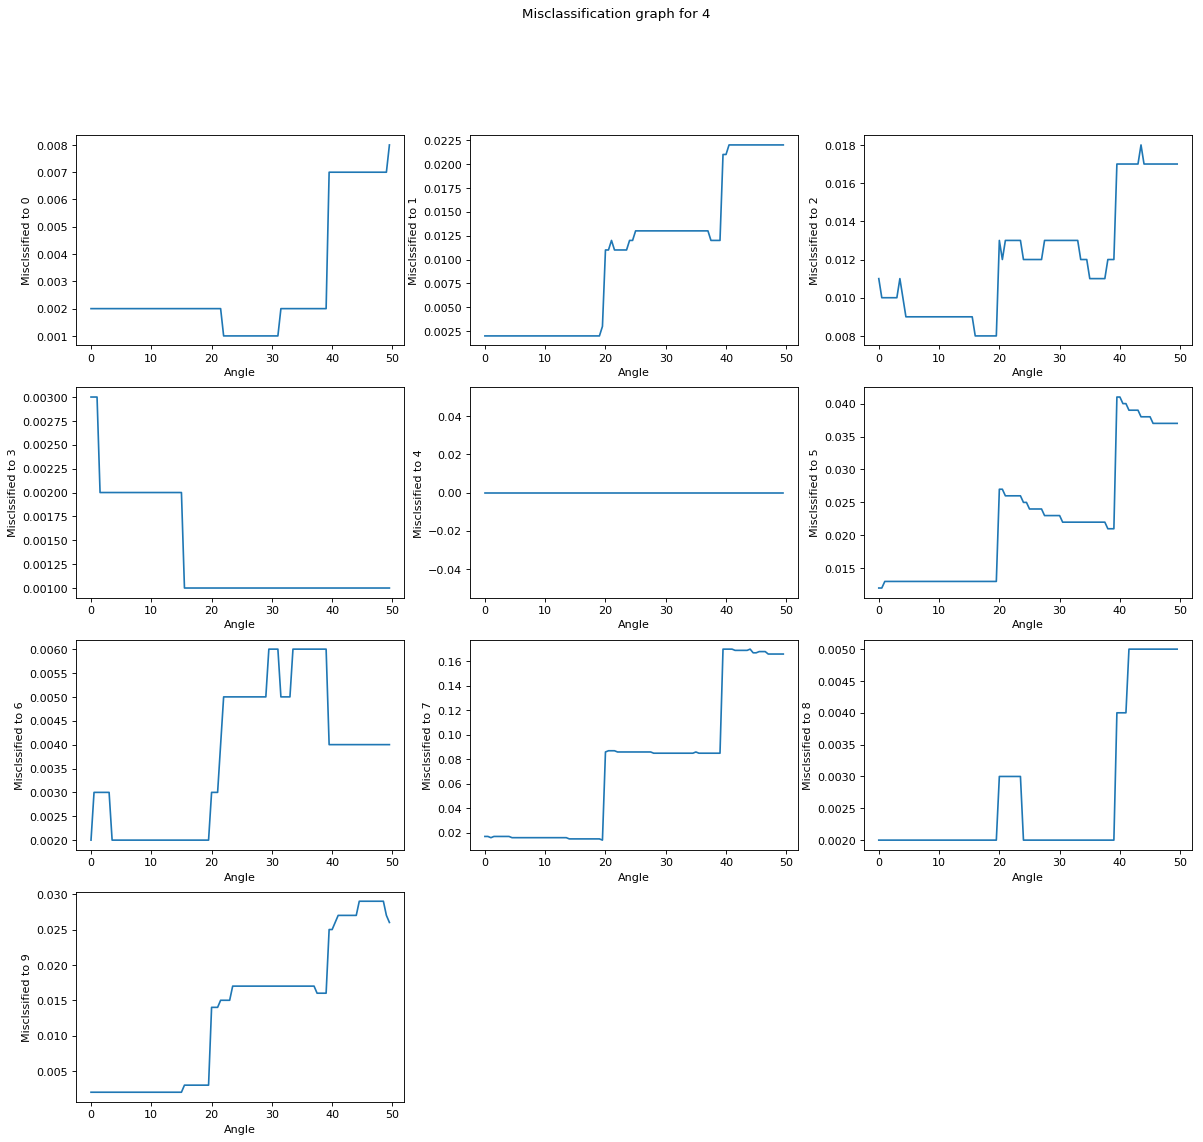

---------------------------------------------------------------------------------------------------------------------


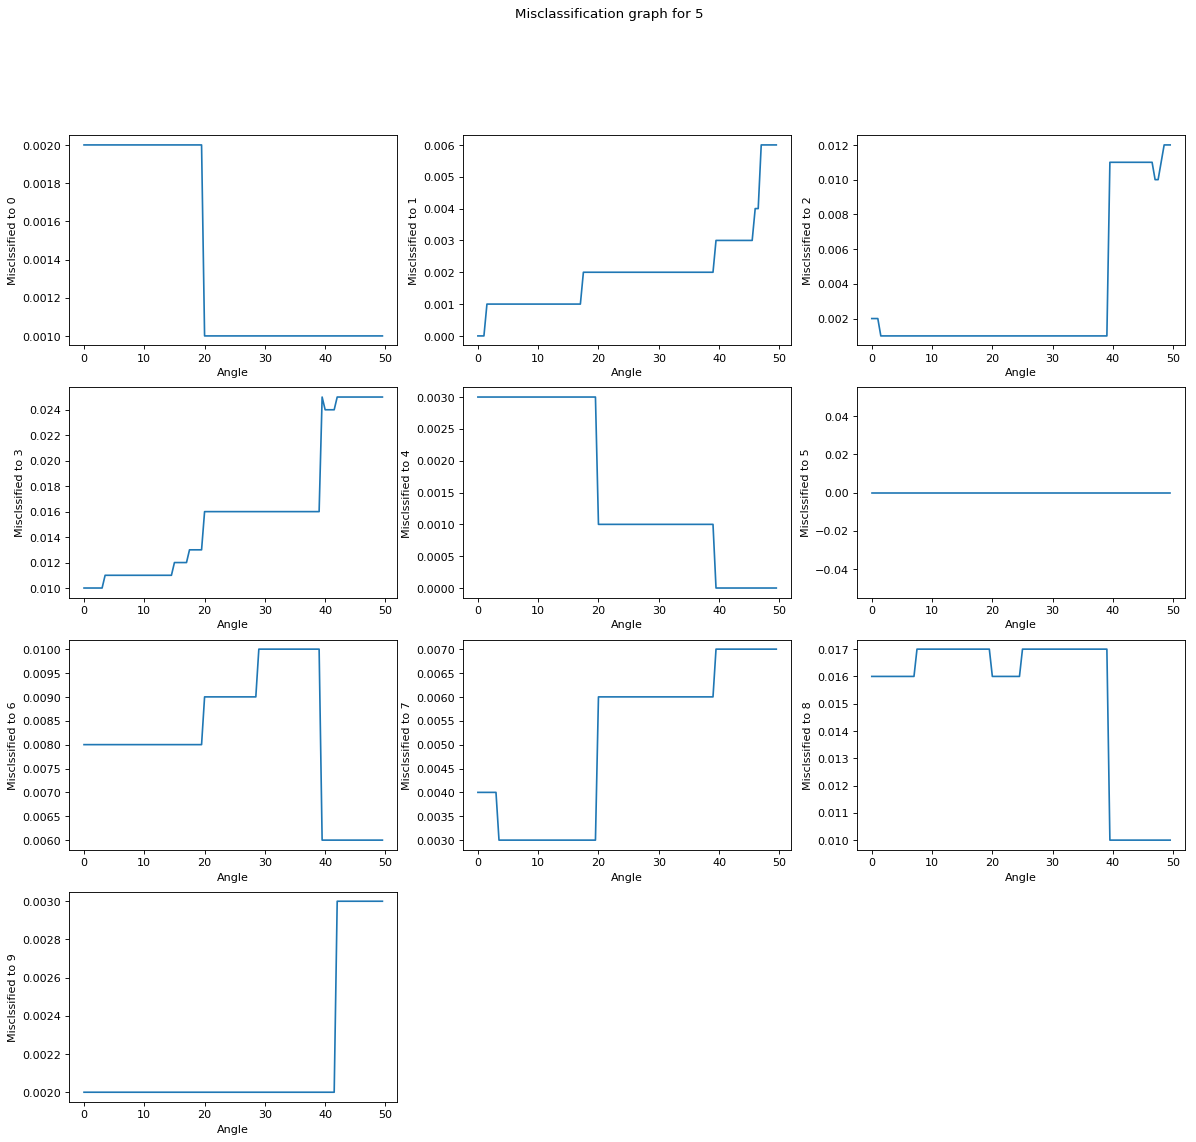

---------------------------------------------------------------------------------------------------------------------


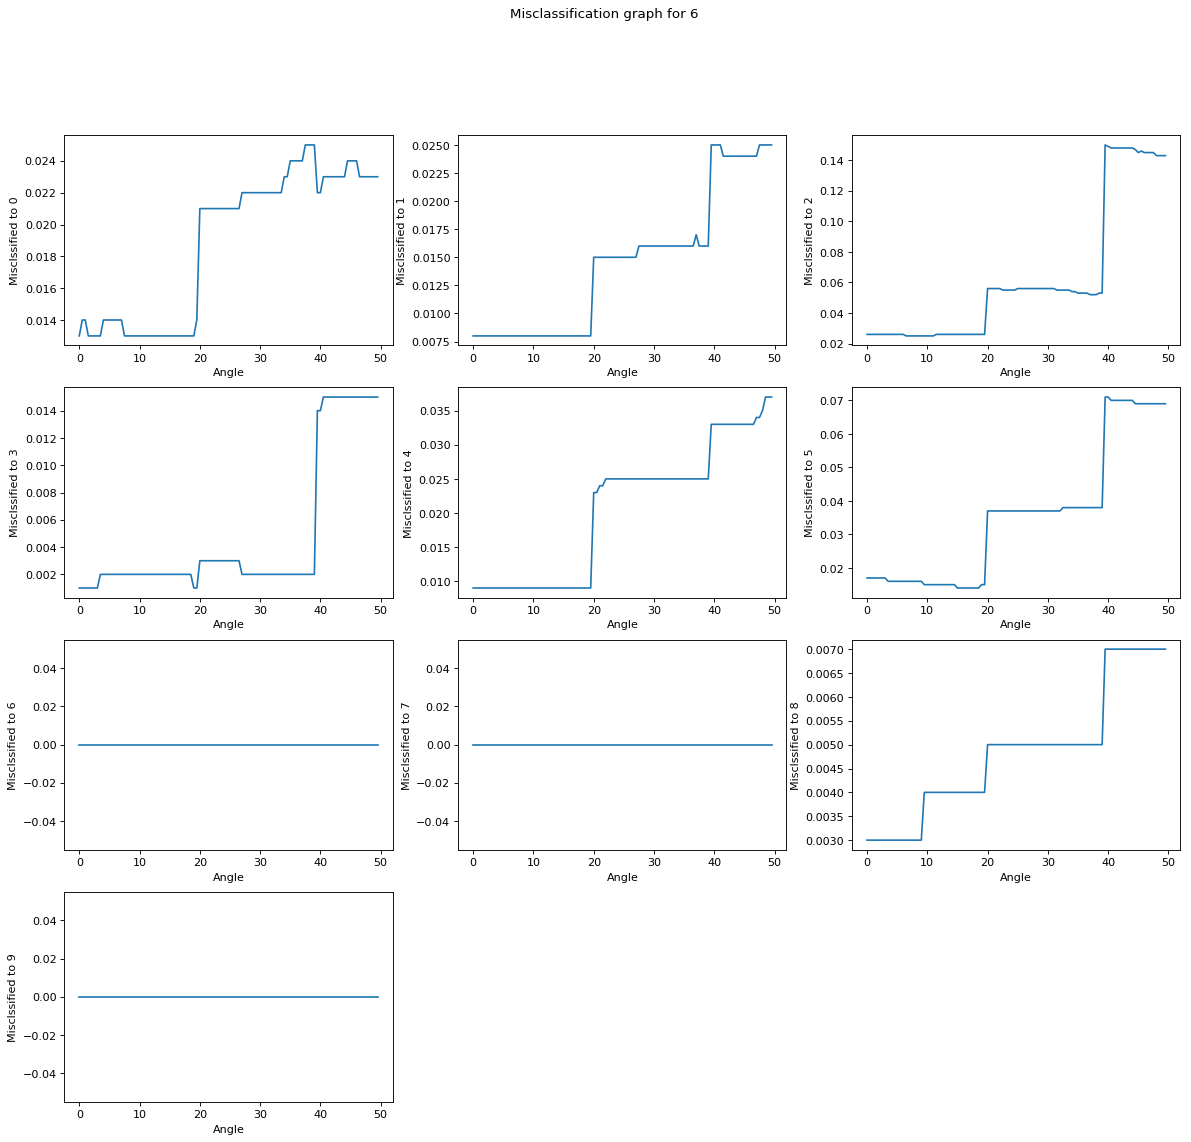

---------------------------------------------------------------------------------------------------------------------


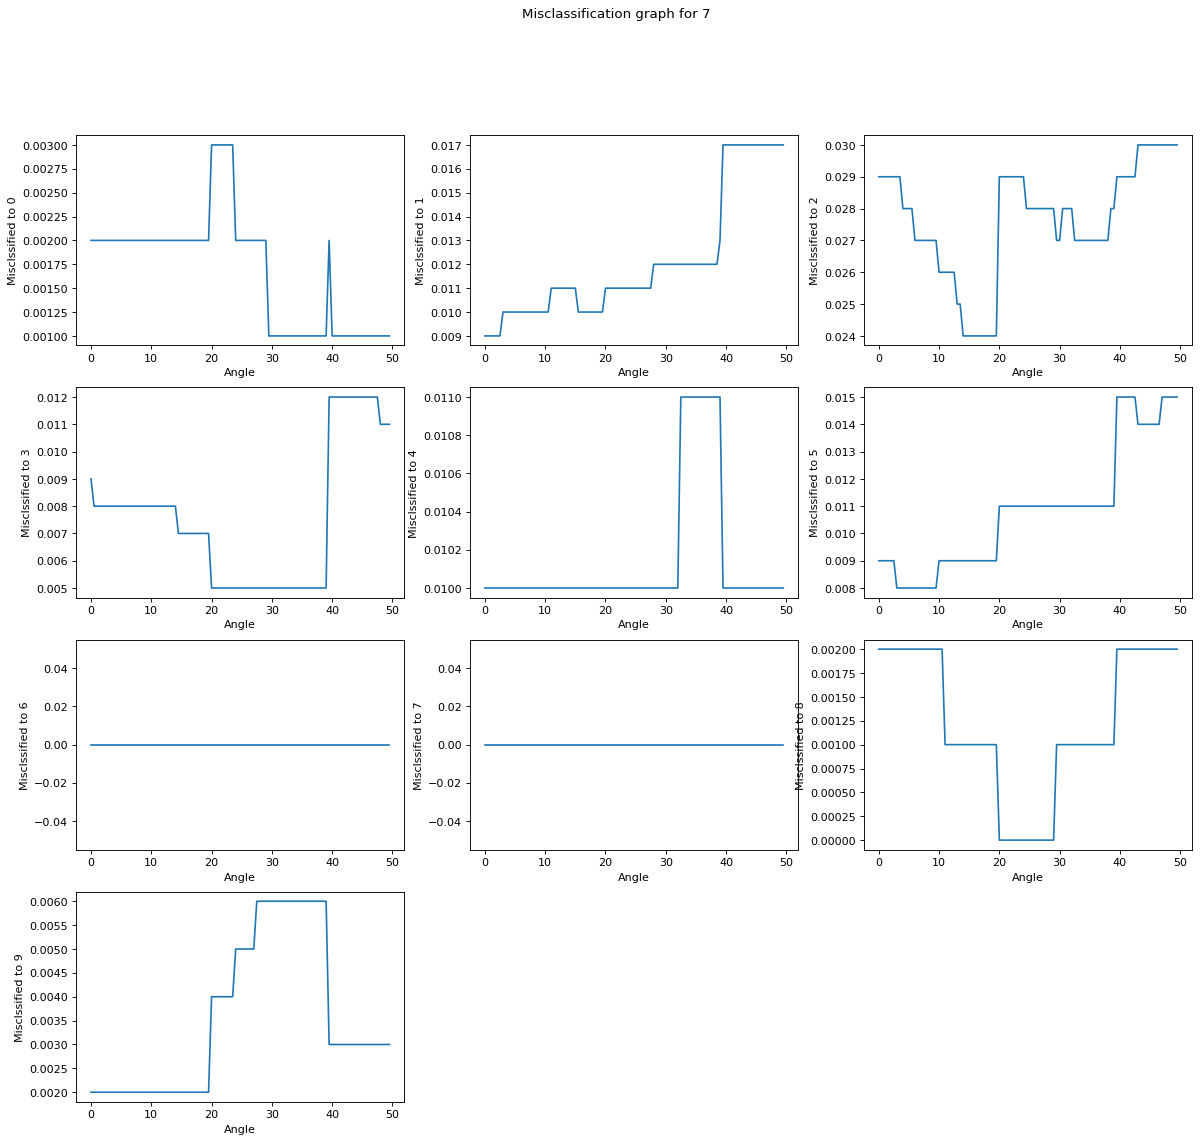

---------------------------------------------------------------------------------------------------------------------


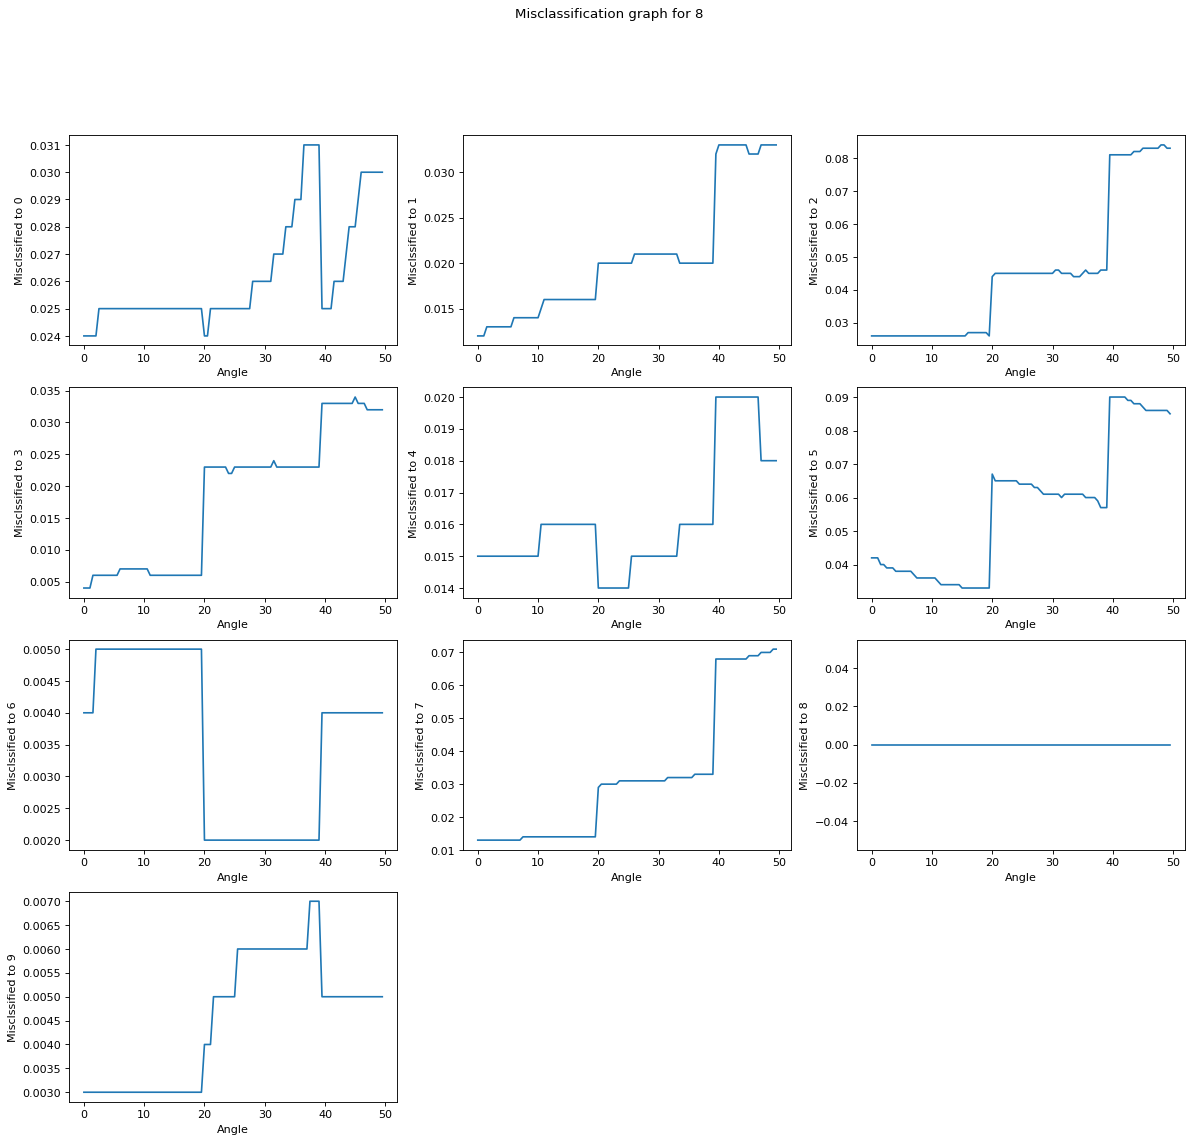

---------------------------------------------------------------------------------------------------------------------


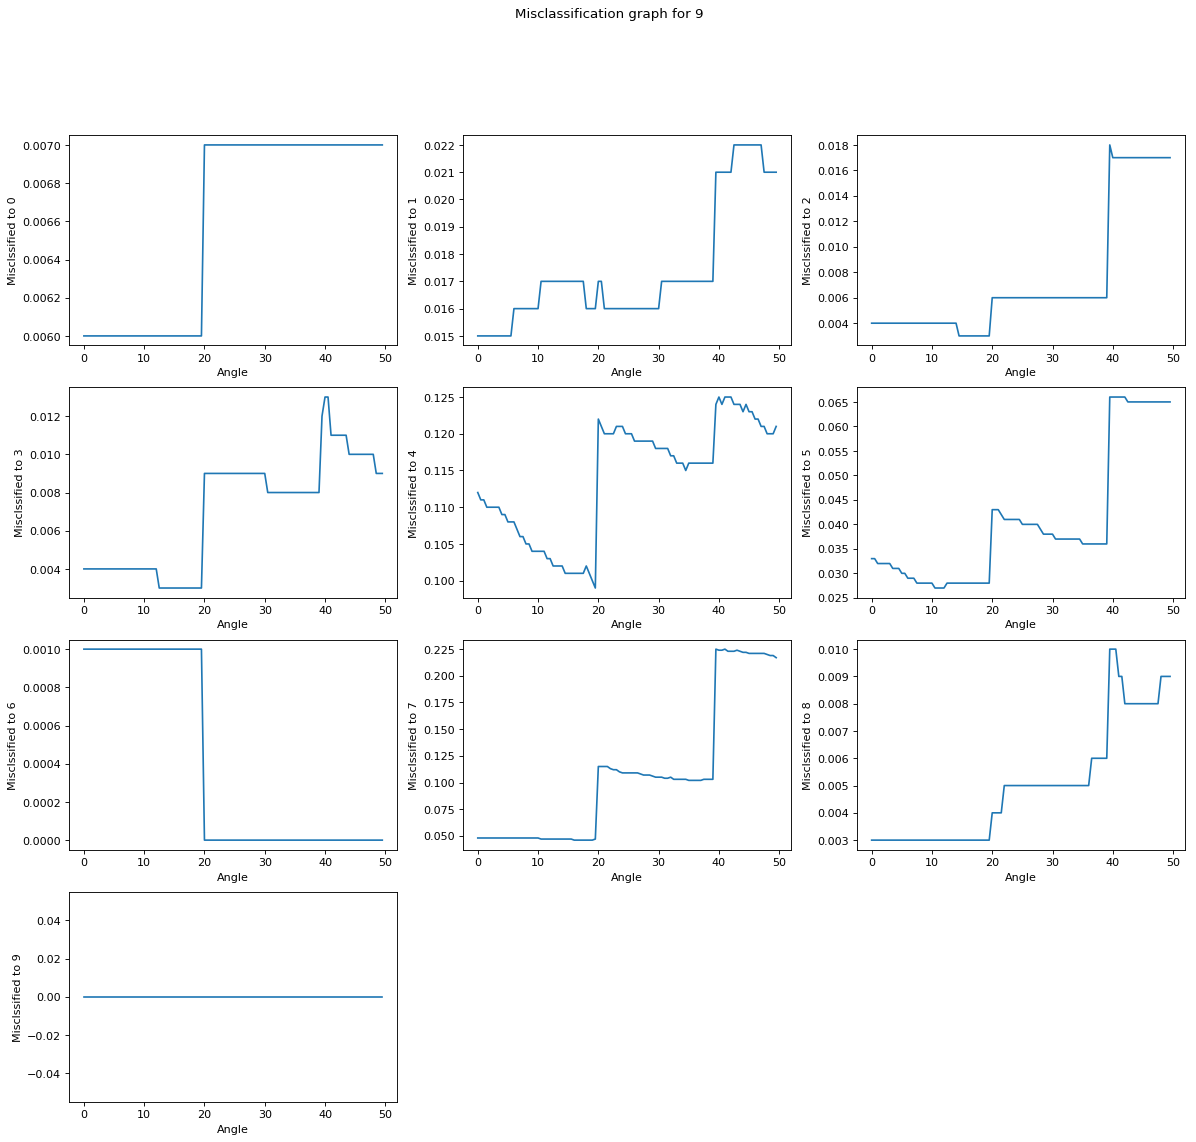

---------------------------------------------------------------------------------------------------------------------


In [13]:
zero = []

for j in range(10):
    figure(num=None, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
    for k in range(0,10):
        zero = []
        if j != k: 
            for i in range(len(aMatrix)):
                zero.append(aMatrix[i][j][k])
        else:
            zero+=100*[0]       
        plt.subplot(4,3,k+1)
        plt.plot(np.arange(0,50,0.5),zero)
        plt.xlabel("Angle")
        plt.ylabel("Misclssified to %s" %str(k))
    plt.suptitle("Misclassification graph for %d" %(j))
    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------")